# Quickstart: NOAA HRRR analysis - dynamical.org Icechunk Zarr
A brief introduction to the NOAA HRRR analysis dataset transformed into an analysis-ready, cloud-optimized format by dynamical.org.

Dataset documentation: https://dynamical.org/catalog/noaa-hrrr-analysis/

In [ ]:
# If running locally, follow README.md for simple dependency installation.
# If using Google Colab, run this cell and then restart the notebook.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.8" icechunk rioxarray pyproj
# rioxarray and pyproj are used here for working with map projections

In [1]:
import icechunk
import xarray as xr

storage = icechunk.s3_storage(bucket="dynamical-noaa-hrrr", prefix="noaa-hrrr-analysis/v0.1.0.icechunk/", region="us-west-2", anonymous=True)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session("main")
ds = xr.open_zarr(session.store, chunks=None)
ds

<xarray.Dataset> Size: 10TB
Dimensions:                                     (time: 64434, y: 1059, x: 1799)
Coordinates:
    latitude                                    (y, x) float32 8MB ...
    longitude                                   (y, x) float32 8MB ...
    spatial_ref                                 int64 8B ...
  * time                                        (time) datetime64[ns] 515kB 2...
  * x                                           (x) float64 14kB -2.698e+06 ....
  * y                                           (y) float64 8kB 1.587e+06 ......
Data variables: (12/20)
    categorical_freezing_rain_surface           (time, y, x) float32 491GB ...
    categorical_ice_pellets_surface             (time, y, x) float32 491GB ...
    categorical_rain_surface                    (time, y, x) float32 491GB ...
    categorical_snow_surface                    (time, y, x) float32 491GB ...
    composite_reflectivity                      (time, y, x) float32 491GB ...
    downward_long_wave_radiation_flux_surface   (time, y, x) float32 491GB ...
    ...                                          ...
    temperature_2m                              (time, y, x) float32 491GB ...
    total_cloud_cover_atmosphere                (time, y, x) float32 491GB ...
    wind_u_10m                                  (time, y, x) float32 491GB ...
    wind_u_80m                                  (time, y, x) float32 491GB ...
    wind_v_10m                                  (time, y, x) float32 491GB ...
    wind_v_80m                                  (time, y, x) float32 491GB ...
Attributes:
    dataset_id:          noaa-hrrr-analysis
    dataset_version:     0.1.0
    name:                NOAA HRRR analysis
    description:         Analysis data from the High-Resolution Rapid Refresh...
    attribution:         NOAA NWS NCEP HRRR data processed by dynamical.org f...
    spatial_domain:      Continental United States
    spatial_resolution:  3 km
    time_domain:         2018-09-16 00:00:00 UTC to Present
    time_resolution:     1 hour

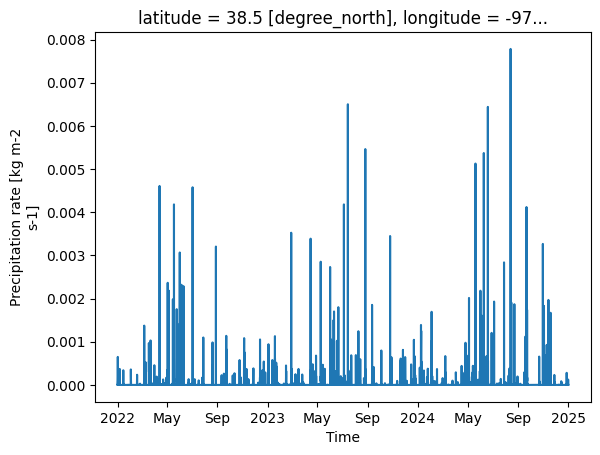

In [2]:
# Precipitation over time at a point
(
    ds["precipitation_surface"]
    .sel(x=0, y=0, method="nearest")
    .sel(time=slice("2022-01-01T00:00", "2025-01-01T00:00"))
    .plot()
)

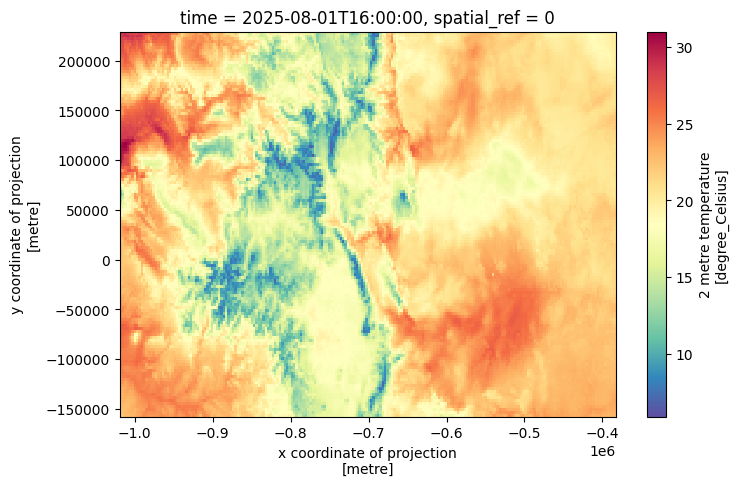

In [3]:
# Temperature map over Colorado at a point in time
(
    ds["temperature_2m"]
    .rio.clip_box(-109, 37, -102, 40, crs="EPSG:4326")  # auto translates coordinate reference system
    .sel(time="2025-08-01T16:00")
    .plot(figsize=(8, 5), cmap="Spectral_r")
)

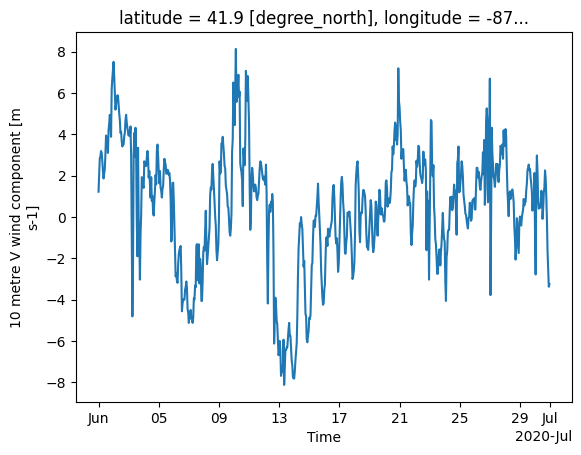

In [4]:
# HRRR data is distributed in a projected coordinate reference system and
# we include its details in the dataset metadata (e.g. ds.rio.crs, ds.rio.transform()).

# Use pyproj to transform the longitude and latitude of Chicago, IL into dataset x, y coordinates
from pyproj import Transformer

lon_lat_to_ds = Transformer.from_crs("EPSG:4326", ds.rio.crs, always_xy=True)
x, y = lon_lat_to_ds.transform(-87.6, 41.9)

ds["wind_v_10m"].sel(x=x, y=y, method="nearest").sel(time=slice("2020-06-01", "2020-06-30")).plot()

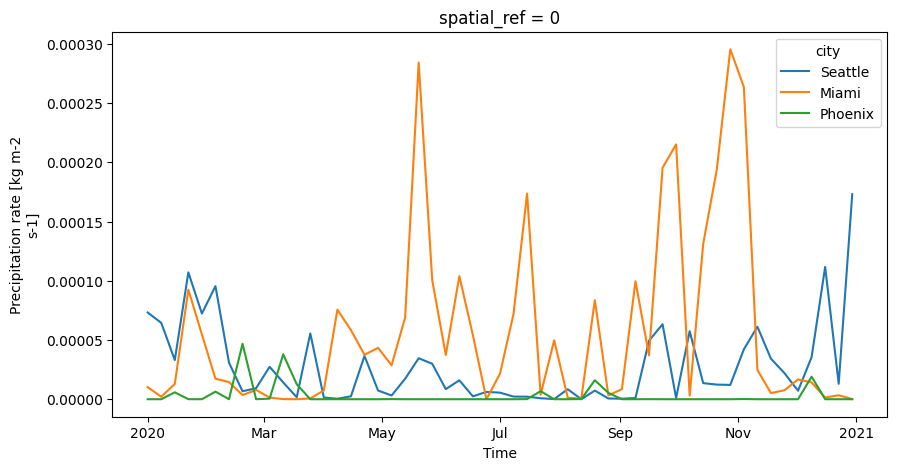

In [5]:
# Select multiple US cities and compare precipitation patterns

import pandas as pd

cities = pd.DataFrame(
    [
        {"city": "Seattle", "latitude": 47.6, "longitude": -122.3},
        {"city": "Miami", "latitude": 25.8, "longitude": -80.2},
        {"city": "Phoenix", "latitude": 33.4, "longitude": -112.1},
    ]
).set_index("city")

# Transform coordinates
cities["x"], cities["y"] = lon_lat_to_ds.transform(cities["longitude"], cities["latitude"])
cities_ds = cities[["x", "y"]].to_xarray()

(
    ds["precipitation_surface"]
    .sel(time=slice("2020-01-01", "2020-12-31"))
    .sel(x=cities_ds.x, y=cities_ds.y, method="nearest")
    .resample(time="7d").mean()
    .plot(hue="city", size=5, aspect=2)
)

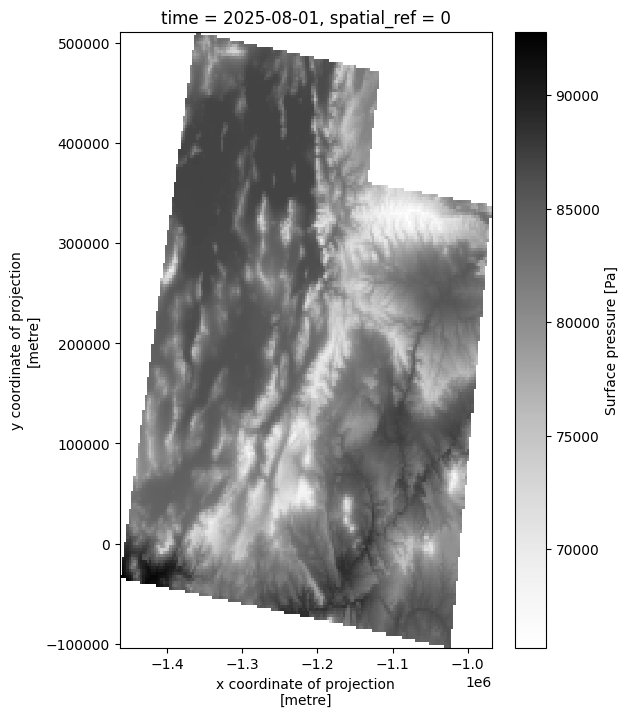

In [6]:
# Clip to geometries

# Here we use a list of one polygon that approximates the shape of the state of Utah
roughly_utah = {
    "type": "Polygon",
    "coordinates": [
        [
            [-114.04, 41.99],
            [-114.05, 37.00],
            [-109.04, 36.99],
            [-109.05, 40.99],
            [-111.04, 40.99],
            [-111.04, 42.00],
            [-114.04, 41.99],
        ]
    ],
}
geometries = [roughly_utah]

(
    ds["pressure_surface"]
    .sel(time="2025-08-01T00")
    .rio.clip(geometries, crs="EPSG:4326")
    .plot(figsize=(6, 8), cmap="Greys")
)

# To aggregate data over one or more geometries (e.g. countries, or arbitrary polygons),
# see xvec library's zonal statistics functions: https://xvec.readthedocs.io/.

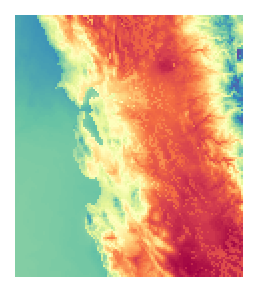

In [7]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# An interactive animation of temperature over time in the San Francisco Bay Area

data = (
    ds["temperature_2m"]
    .rio.clip_box(-123, 36, -120, 39, crs="EPSG:4326")
    .sel(time=slice("2021-06-25T00", "2021-07-02T00"))
    .load()
)

dpi=150
fig, ax = plt.subplots(figsize=(2 * data.x.size/dpi, 2 * data.y.size/dpi), dpi=dpi)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.axis("off")

img = ax.imshow(data.isel(time=0), cmap='Spectral_r')
anim = FuncAnimation(fig=fig, frames=data, func=lambda frame: img.set_data(frame), interval=80)

HTML(anim.to_jshtml())